# ⚡️ 에너지 기반 모델

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/07_ebm/01_ebm/ebm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
    # output 디렉토리를 만듭니다.
    !mkdir output
    !mkdir models

--2024-04-08 04:10:55--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-04-08 04:10:55 (40.7 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 데모 데이터셋의 분포를 예측하기 위해 에너지 기반 모델을 훈련합니다.

이 코드는 Phillip Lippe가 만든 훌륭한 ['심층 에너지 기반 생성 모델' 튜토리얼](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html)을 참고했습니다.

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

from notebooks.utils import display, sample_batch
import random

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [4]:
# 데이터 로드
(x_train, _), (x_test, _) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
# 데이터 전처리

def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

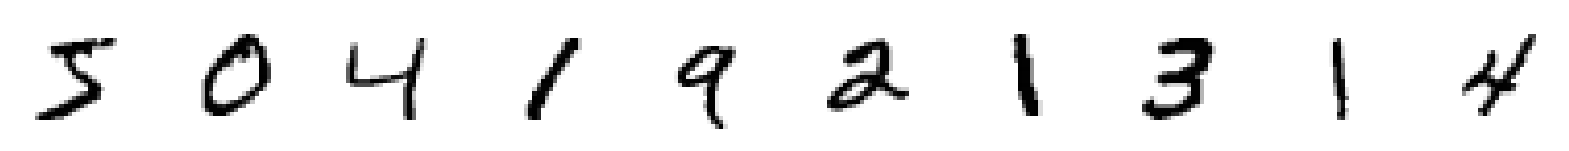

In [7]:
# 훈련 세트의 일부 샘플 표시
train_sample = sample_batch(x_train)
display(train_sample)

## 2. EBM 신경망 만들기 <a name="train"></a>

In [8]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [9]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. 랑주뱅 샘플링 함수 <a name="sampler"></a>

In [10]:
# 랑주뱅 동역학을 사용하여 샘플을 생성하는 함수
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. 샘플을 저장할 버퍼 설정 <a name="buffer"></a>

In [11]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [12]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [13]:
ebm = EBM()

## 3. EBM 신경망 훈련하기 <a name="train"></a>

In [14]:
# 모델 컴파일 및 훈련
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [15]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [16]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/10


469/469 [==============================] - ETA: 0s - loss: -0.0353 - reg: 0.0116 - cdiv: -0.0469 - real: 0.1848 - fake: 0.1379
Saved to ./output/generated_img_000.png


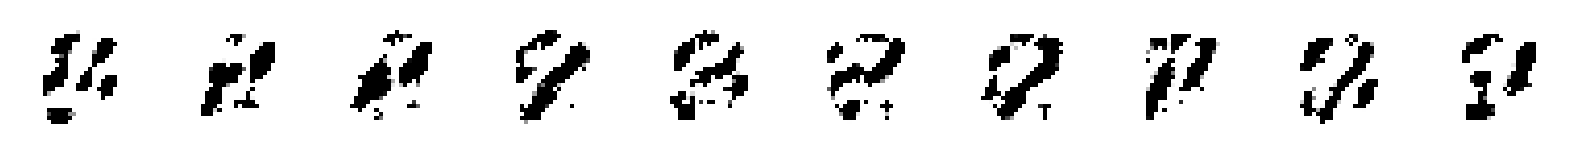


Saved to ./output/example_img_000.png


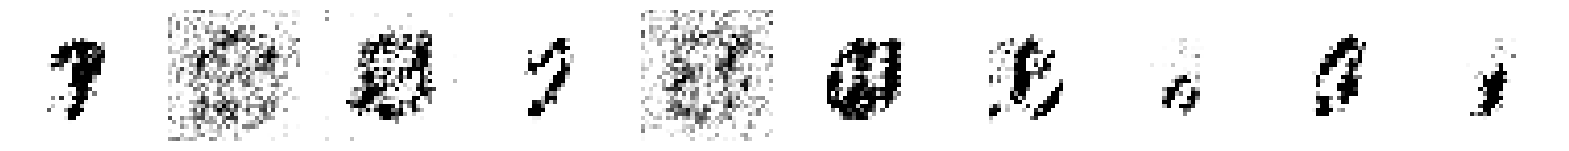

469/469 [==============================] - 598s 1s/step - loss: -0.0353 - reg: 0.0116 - cdiv: -0.0469 - real: 0.1848 - fake: 0.1379 - val_cdiv: -1.4815 - val_real: -0.1049 - val_fake: -1.5864
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: -0.0014 - reg: 0.0018 - cdiv: -0.0031 - real: 0.0080 - fake: 0.0049
Saved to ./output/generated_img_001.png


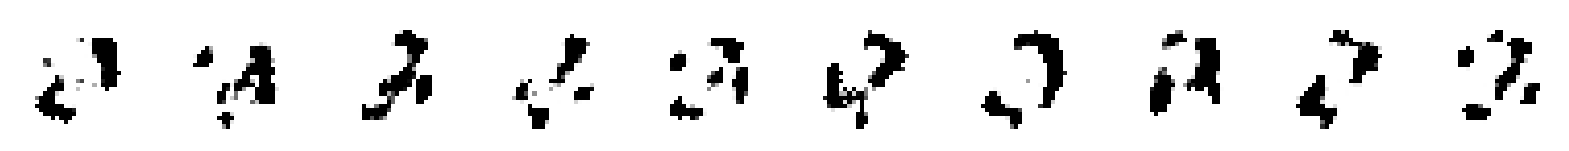


Saved to ./output/example_img_001.png


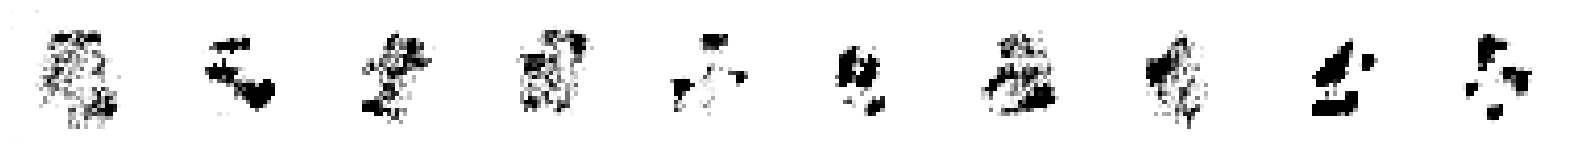

469/469 [==============================] - 583s 1s/step - loss: -0.0014 - reg: 0.0018 - cdiv: -0.0031 - real: 0.0080 - fake: 0.0049 - val_cdiv: -1.6608 - val_real: -0.0863 - val_fake: -1.7471
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: -0.0015 - reg: 0.0012 - cdiv: -0.0027 - real: 0.0043 - fake: 0.0016
Saved to ./output/generated_img_002.png


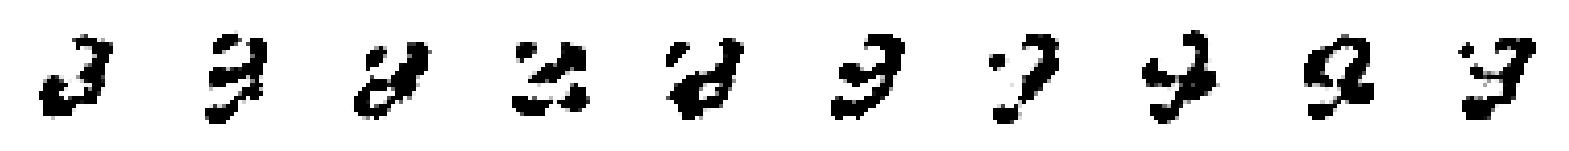


Saved to ./output/example_img_002.png


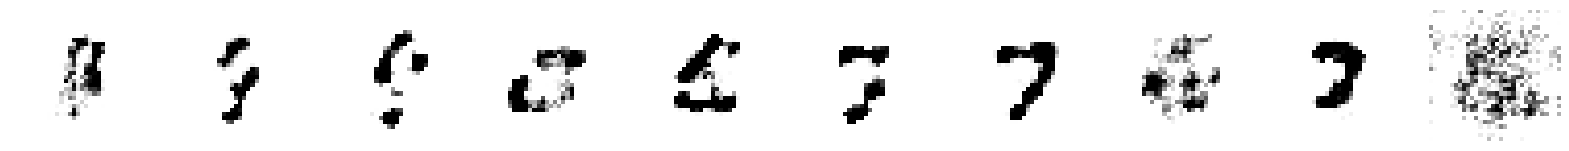

469/469 [==============================] - 586s 1s/step - loss: -0.0015 - reg: 0.0012 - cdiv: -0.0027 - real: 0.0043 - fake: 0.0016 - val_cdiv: -1.9625 - val_real: -0.0530 - val_fake: -2.0154
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 1.2283e-04 - reg: 6.9689e-04 - cdiv: -5.7406e-04 - real: 0.0022 - fake: 0.0017
Saved to ./output/generated_img_003.png


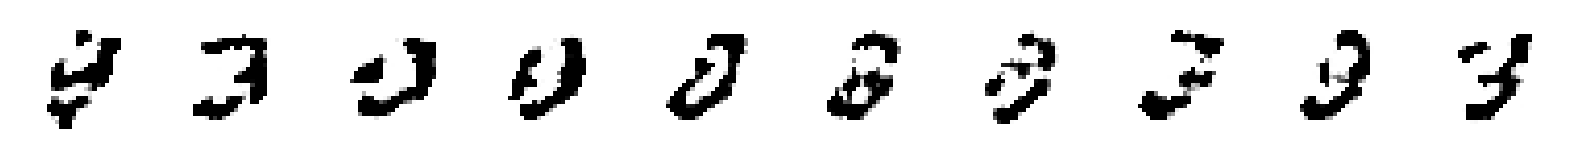


Saved to ./output/example_img_003.png


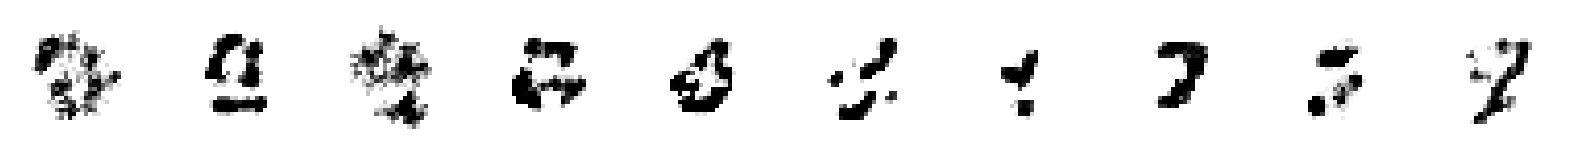

469/469 [==============================] - 592s 1s/step - loss: 1.2283e-04 - reg: 6.9689e-04 - cdiv: -5.7406e-04 - real: 0.0022 - fake: 0.0017 - val_cdiv: -2.1470 - val_real: -0.0306 - val_fake: -2.1775
Epoch 5/10
469/469 [==============================] - ETA: 0s - loss: 1.1209e-04 - reg: 4.3103e-04 - cdiv: -3.1893e-04 - real: 0.0021 - fake: 0.0017
Saved to ./output/generated_img_004.png


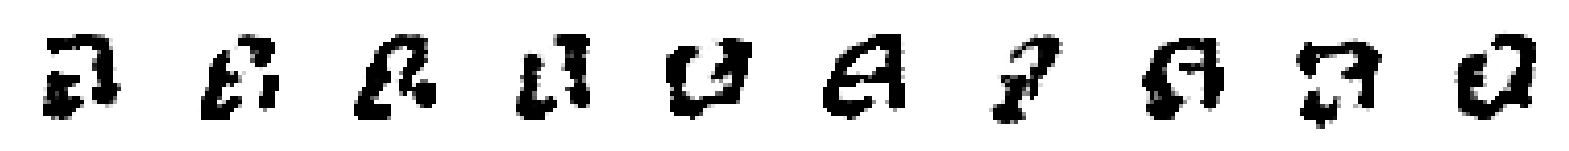


Saved to ./output/example_img_004.png


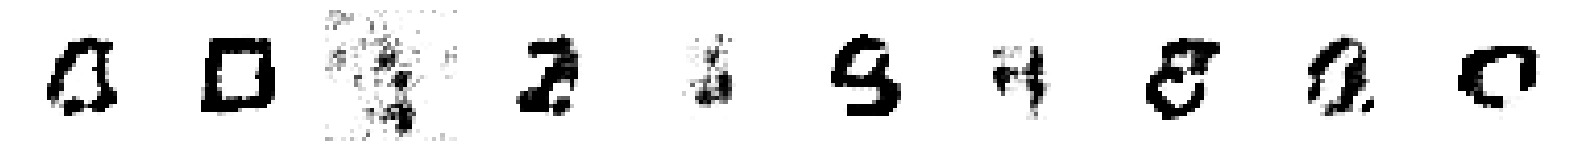

469/469 [==============================] - 591s 1s/step - loss: 1.1209e-04 - reg: 4.3103e-04 - cdiv: -3.1893e-04 - real: 0.0021 - fake: 0.0017 - val_cdiv: -2.4122 - val_real: -0.0315 - val_fake: -2.4437
Epoch 6/10
469/469 [==============================] - ETA: 0s - loss: 5.2761e-04 - reg: 2.8774e-04 - cdiv: 2.3986e-04 - real: 0.0013 - fake: 0.0016
Saved to ./output/generated_img_005.png


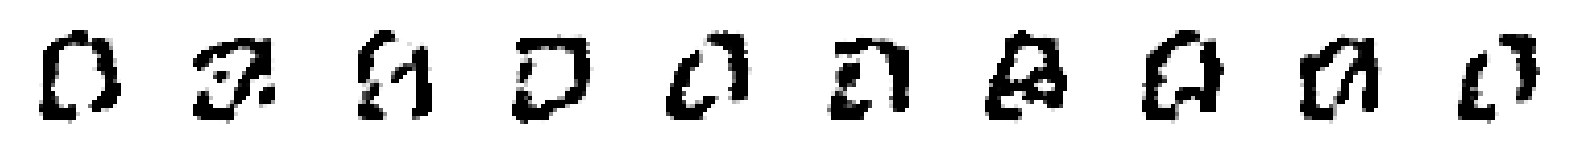


Saved to ./output/example_img_005.png


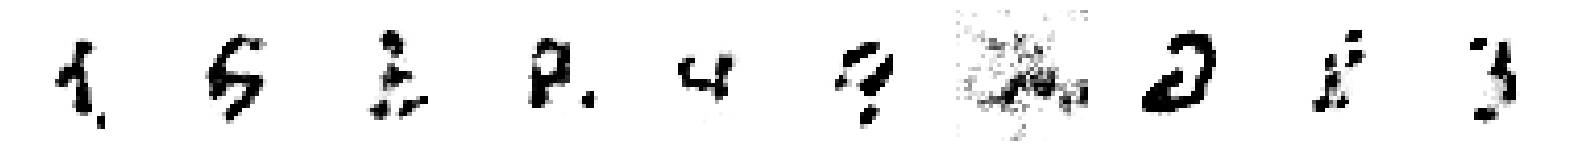

469/469 [==============================] - 590s 1s/step - loss: 5.2761e-04 - reg: 2.8774e-04 - cdiv: 2.3986e-04 - real: 0.0013 - fake: 0.0016 - val_cdiv: -2.6803 - val_real: -0.0243 - val_fake: -2.7046
Epoch 7/10
469/469 [==============================] - ETA: 0s - loss: 7.4047e-04 - reg: 2.1784e-04 - cdiv: 5.2263e-04 - real: 6.0114e-04 - fake: 0.0011
Saved to ./output/generated_img_006.png


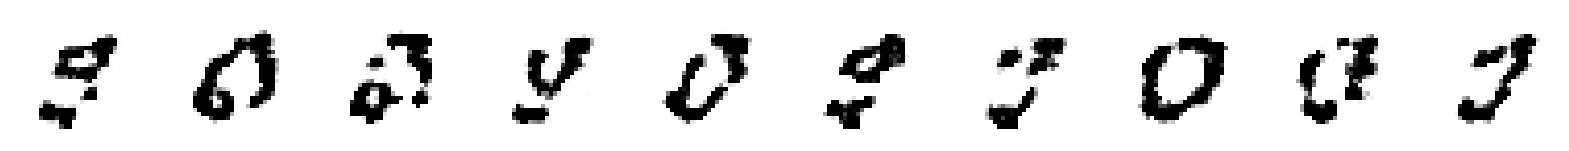


Saved to ./output/example_img_006.png


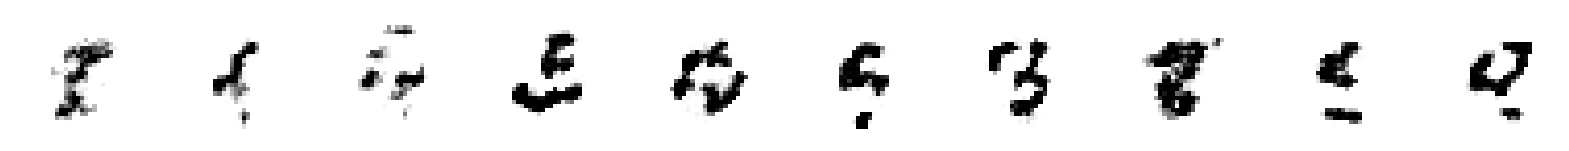

469/469 [==============================] - 597s 1s/step - loss: 7.4047e-04 - reg: 2.1784e-04 - cdiv: 5.2263e-04 - real: 6.0114e-04 - fake: 0.0011 - val_cdiv: -2.8583 - val_real: -0.0206 - val_fake: -2.8789
Epoch 8/10
469/469 [==============================] - ETA: 0s - loss: 5.1467e-04 - reg: 2.1018e-04 - cdiv: 3.0449e-04 - real: 6.1540e-04 - fake: 9.1990e-04
Saved to ./output/generated_img_007.png


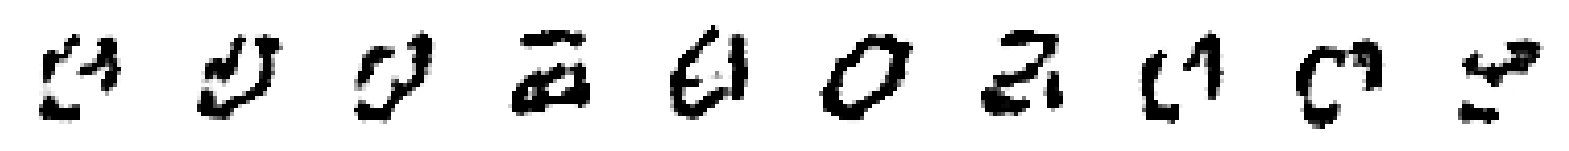


Saved to ./output/example_img_007.png


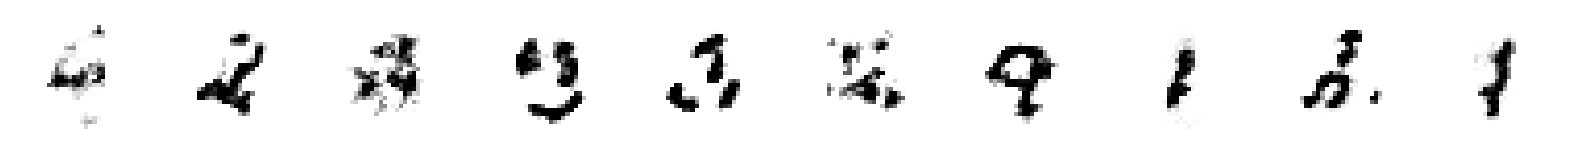

469/469 [==============================] - 590s 1s/step - loss: 5.1467e-04 - reg: 2.1018e-04 - cdiv: 3.0449e-04 - real: 6.1540e-04 - fake: 9.1990e-04 - val_cdiv: -3.1235 - val_real: -0.0089 - val_fake: -3.1324
Epoch 9/10
469/469 [==============================] - ETA: 0s - loss: 2.0411e-04 - reg: 2.1214e-04 - cdiv: -8.0294e-06 - real: 8.7309e-04 - fake: 8.6506e-04
Saved to ./output/generated_img_008.png


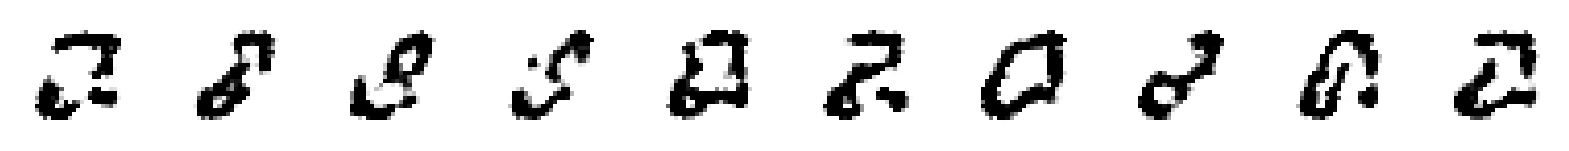


Saved to ./output/example_img_008.png


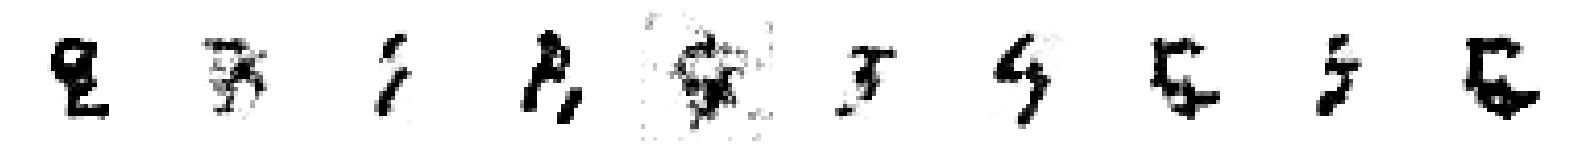

469/469 [==============================] - 600s 1s/step - loss: 2.0411e-04 - reg: 2.1214e-04 - cdiv: -8.0294e-06 - real: 8.7309e-04 - fake: 8.6506e-04 - val_cdiv: -3.4546 - val_real: -0.0220 - val_fake: -3.4766
Epoch 10/10
469/469 [==============================] - ETA: 0s - loss: 7.6004e-04 - reg: 2.3052e-04 - cdiv: 5.2952e-04 - real: 5.5883e-04 - fake: 0.0011
Saved to ./output/generated_img_009.png


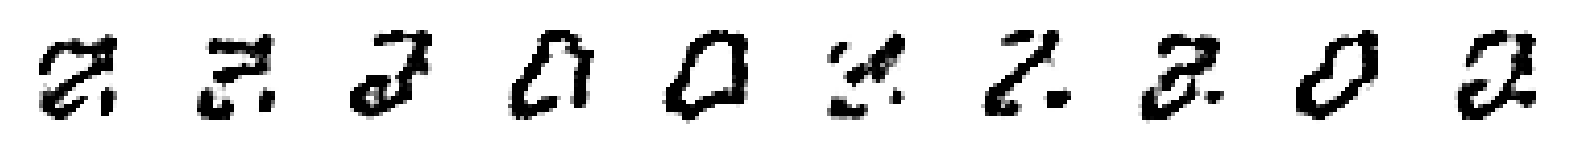


Saved to ./output/example_img_009.png


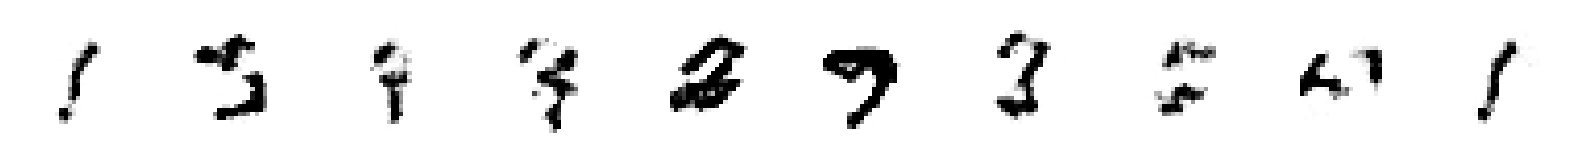

469/469 [==============================] - 601s 1s/step - loss: 7.6004e-04 - reg: 2.3052e-04 - cdiv: 5.2952e-04 - real: 5.5883e-04 - fake: 0.0011 - val_cdiv: -3.6592 - val_real: -0.0129 - val_fake: -3.6721


In [17]:
# 이 셀은 오래 걸리므로 에포크 횟수를 10으로 낮추어 실행합니다.
ebm.fit(
    x_train,
    shuffle=True,
    epochs=10,  # 50
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. 이미지 생성 <a name="generate"></a>

In [18]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

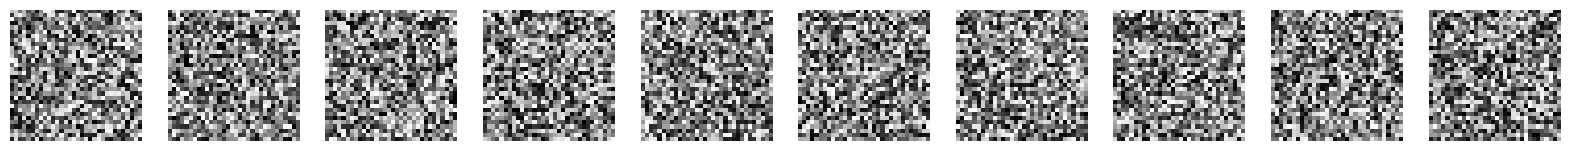

In [19]:
display(start_imgs)

In [20]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

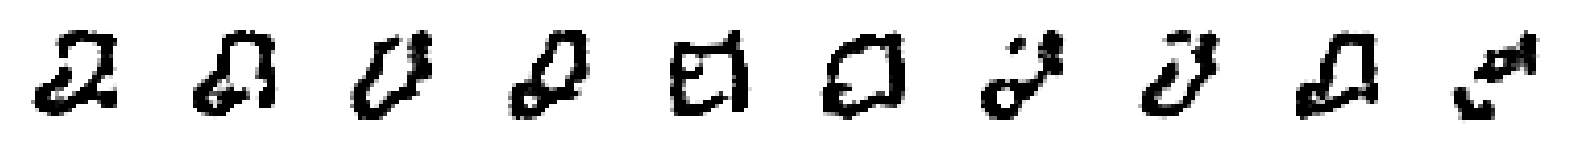

In [21]:
display(gen_img[-1].numpy())

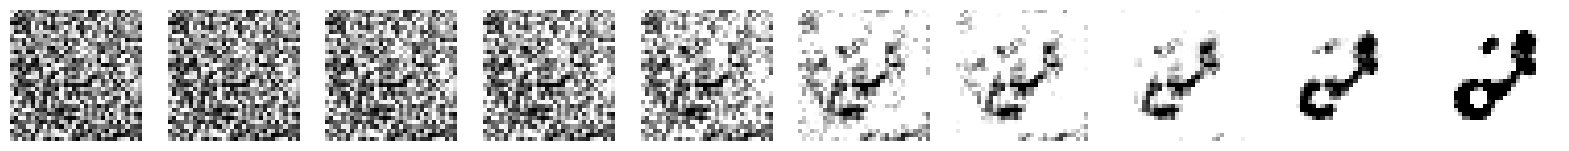

In [22]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))